### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Disable warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

### Data Preparation and Exploration

#### Data Loading

In [24]:
# Load dataset
data = pd.read_csv('exchange_rate.csv',  parse_dates=['date'], dayfirst=True)
data

,date,Ex_rate
0,1990-01-01,0.785500
1,1990-01-02,0.781800
2,1990-01-03,0.786700
3,1990-01-04,0.786000
4,1990-01-05,0.784900
...,...,...
7583,2010-10-06,0.718494
7584,2010-10-07,0.721839
7585,2010-10-08,0.723197
7586,2010-10-09,0.720825


In [26]:
# Display first few rows
data.head()

,date,Ex_rate
0,1990-01-01,0.7855
1,1990-01-02,0.7818
2,1990-01-03,0.7867
3,1990-01-04,0.7860
4,1990-01-05,0.7849


In [28]:
# Set the date column as the index:
data.set_index('date', inplace=True)

In [30]:
data.shape

(7588, 1)

In [32]:
# Summary Statistics:
data.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [34]:
# Checking for missing values:
# There are no missing values found.
data.isna().sum()

Ex_rate    0
dtype: int64

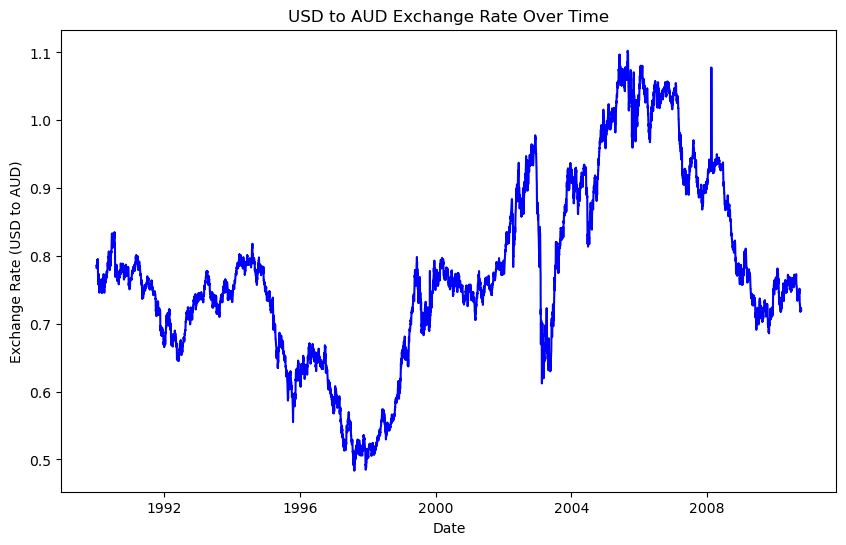

In [36]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(data, color='blue')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD to AUD)')
plt.show()

### Model Building - ARIMA

#### Parameter Selection for ARIMA

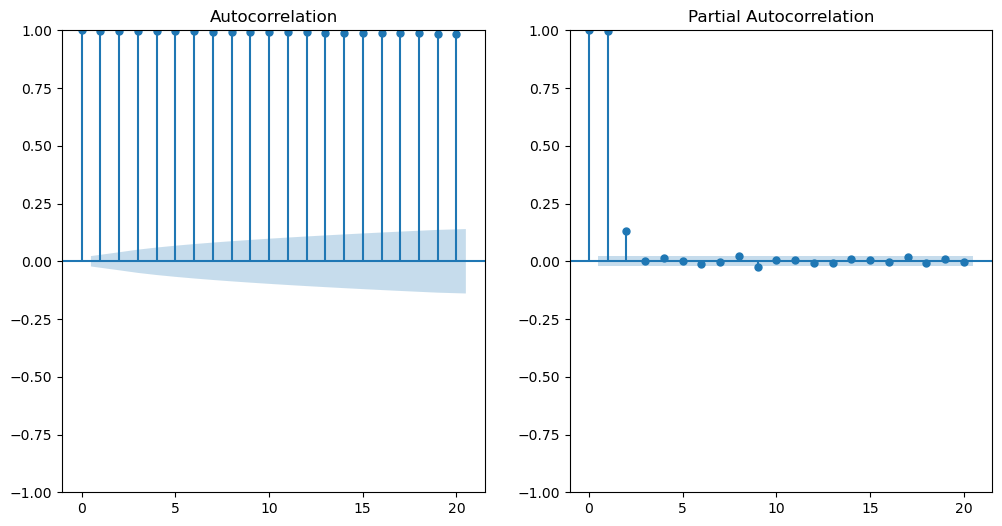

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data, ax=plt.gca(), lags=20)
plt.subplot(122)
plot_pacf(data, ax=plt.gca(), lags=20)
plt.show()

#### Model Fitting

In [47]:
# Define ARIMA model parameters based on observations from ACF and PACF
p, d, q = 1, 1, 1  # Example parameters; use values determined from plots

# Fit the ARIMA model
arima_model = ARIMA(data, order=(p, d, q))
arima_fitted = arima_model.fit()
print(arima_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sun, 27 Oct 2024   AIC                         -56102.322
Time:                        22:24:40   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

#### Diagnostics

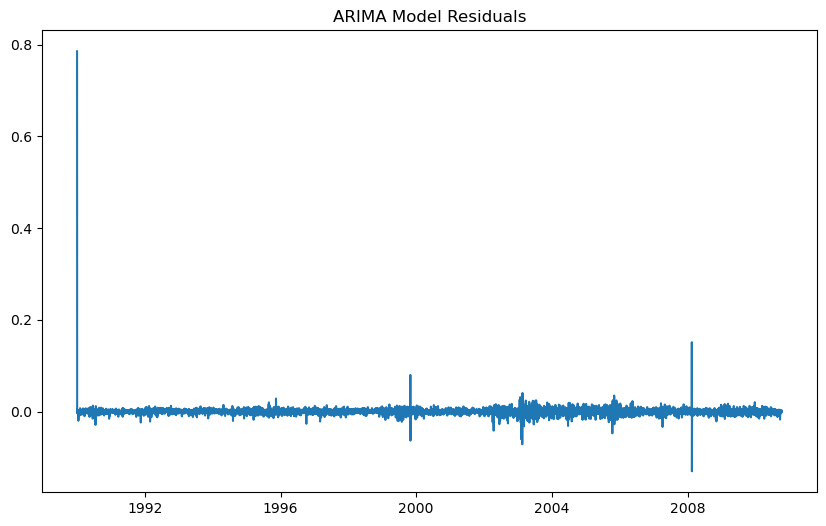

In [50]:
# Plot residuals to check for patterns
residuals = arima_fitted.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('ARIMA Model Residuals')
plt.show()

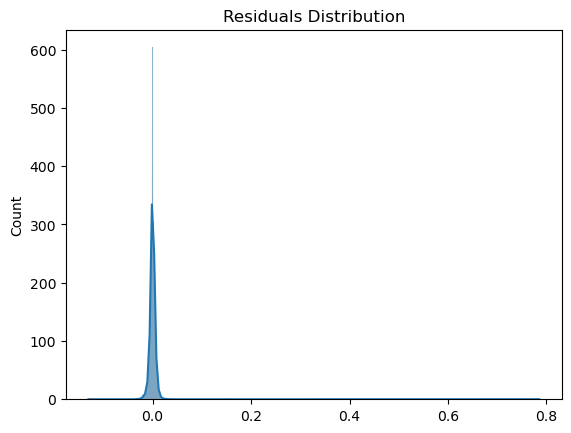

In [52]:
# Histogram of residuals
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

#### Forecasting

In [55]:
# Forecast future values
forecast_steps = 30
forecast = arima_fitted.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

In [57]:
forecast_ci

,lower Ex_rate,upper Ex_rate
2010-10-11,0.709074,0.732579
2010-10-12,0.705259,0.736393
2010-10-13,0.702103,0.739550
2010-10-14,0.699418,0.742234
2010-10-15,0.697033,0.744619
2010-10-16,0.694867,0.746786
2010-10-17,0.692868,0.748785
2010-10-18,0.691003,0.750650
2010-10-19,0.689247,0.752405
2010-10-20,0.687584,0.754068


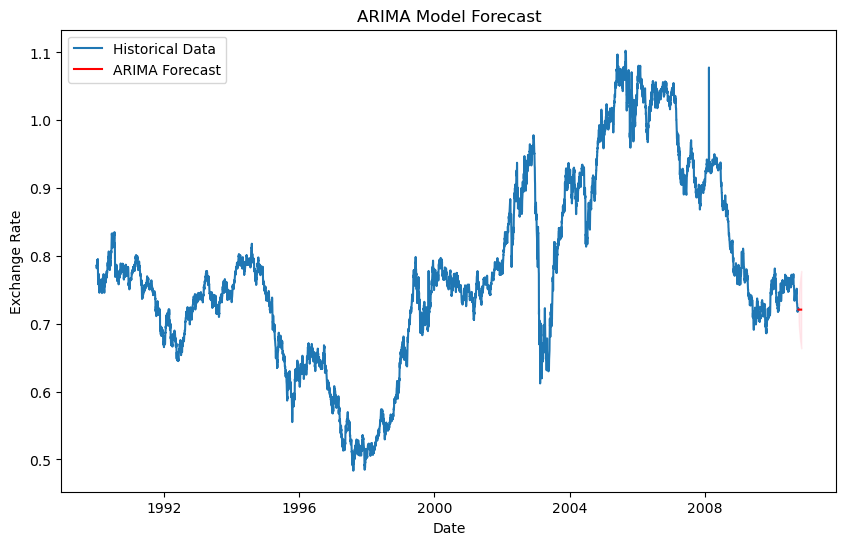

In [59]:
# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(data, label='Historical Data')
plt.plot(forecast.predicted_mean, color='red', label='ARIMA Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

### Model Building - Exponential Smoothing

#### Model Selection
Choose based on data patterns:

-Simple Exponential Smoothing if stationary

-Holt’s Linear Trend if there is a trend

-Holt-Winters if seasonality and trend are present.

Using Holt’s Linear Trend model due to the time-series trend:

In [65]:
# Fit Holt’s Linear model
holt_model = ExponentialSmoothing(data, trend="add", seasonal=None)
holt_fitted = holt_model.fit()

In [67]:
# Forecast future values
holt_forecast = holt_fitted.forecast(steps=forecast_steps)

In [69]:
holt_forecast

2010-10-11    0.720851
2010-10-12    0.720843
2010-10-13    0.720834
2010-10-14    0.720826
2010-10-15    0.720817
2010-10-16    0.720809
2010-10-17    0.720800
2010-10-18    0.720792
2010-10-19    0.720783
2010-10-20    0.720775
2010-10-21    0.720766
2010-10-22    0.720757
2010-10-23    0.720749
2010-10-24    0.720740
2010-10-25    0.720732
2010-10-26    0.720723
2010-10-27    0.720715
2010-10-28    0.720706
2010-10-29    0.720698
2010-10-30    0.720689
2010-10-31    0.720681
2010-11-01    0.720672
2010-11-02    0.720664
2010-11-03    0.720655
2010-11-04    0.720647
2010-11-05    0.720638
2010-11-06    0.720630
2010-11-07    0.720621
2010-11-08    0.720612
2010-11-09    0.720604
Freq: D, dtype: float64

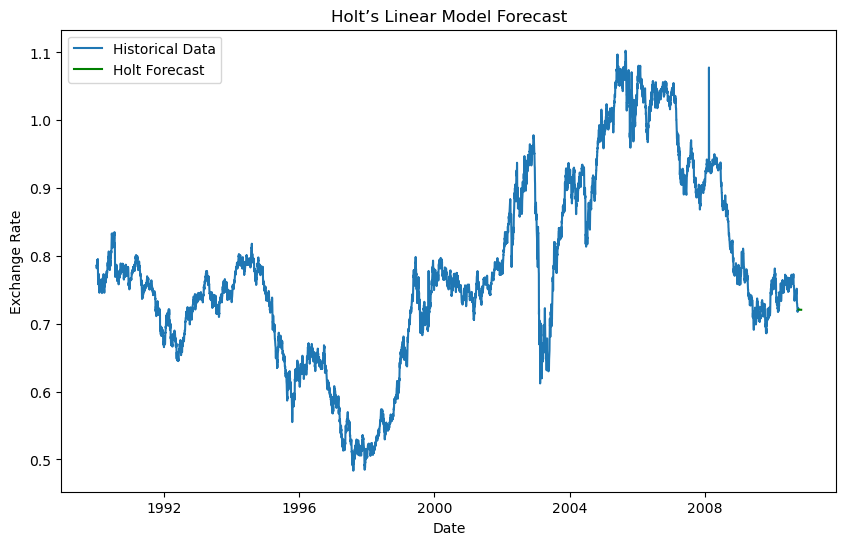

In [71]:
# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(data, label='Historical Data')
plt.plot(holt_forecast, color='green', label='Holt Forecast')
plt.title("Holt’s Linear Model Forecast")
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

### Evaluation and Comparison

#### Compute Error Metrics

In [79]:
# ARIMA error metrics
arima_forecast_values = forecast.predicted_mean
mae_arima = mean_absolute_error(data[-forecast_steps:], arima_forecast_values)
rmse_arima = np.sqrt(mean_squared_error(data[-forecast_steps:], arima_forecast_values))
mape_arima = np.mean(np.abs((data[-forecast_steps:] - arima_forecast_values) / data[-forecast_steps:])) * 100

print(f"ARIMA - MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}, MAPE: {mape_arima:.4f}")

ARIMA - MAE: 0.0127, RMSE: 0.0170, MAPE: nan


In [81]:
# Exponential Smoothing error metrics
mae_holt = mean_absolute_error(data[-forecast_steps:], holt_forecast)
rmse_holt = np.sqrt(mean_squared_error(data[-forecast_steps:], holt_forecast))
mape_holt = np.mean(np.abs((data[-forecast_steps:] - holt_forecast) / data[-forecast_steps:])) * 100

print(f"Holt - MAE: {mae_holt:.4f}, RMSE: {rmse_holt:.4f}, MAPE: {mape_holt:.4f}")

Holt - MAE: 0.0128, RMSE: 0.0170, MAPE: nan


In [ ]:
In this case, both models—ARIMA and Holt’s Linear Exponential Smoothing—produced nearly identical results in terms of **MAE** (Mean Absolute Error) and **RMSE** (Root Mean Squared Error):

- **ARIMA**: 
  - MAE: 0.0127
  - RMSE: 0.0170
  - MAPE: `NaN`

- **Holt**:
  - MAE: 0.0128
  - RMSE: 0.0170
  - MAPE: `NaN`

### Analysis
1. **MAE and RMSE**: Since both models have very close MAE and RMSE values (with ARIMA having a slightly lower MAE), this indicates they both perform similarly well in terms of capturing the general trends in the data and minimizing error.

2. **MAPE**: The `NaN` result for MAPE usually occurs when the actual values contain zeros, causing a division by zero when calculating MAPE. To address this, it may help to add a small constant to the denominator or exclude instances with zero values in the calculation. However, since both models have identical MAPE values, this metric does not contribute to the model comparison.

### Conclusion
Since the MAE and RMSE are almost identical, **both ARIMA and Holt’s Linear Model perform equally well** in this case. If further interpretability or computational efficiency is a consideration, Holt’s model might be preferred due to its simplicity and faster fitting process. However, for slightly lower MAE, ARIMA could be selected if the difference is significant for your application.